Redoing the period fits with everything I've learned from GD394 etc.

In [5]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting
from astropy.timeseries import LombScargle

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [13]:
wddvs = Table.read('dv_lists/wd_dvs.ecsv')
mddvs = Table.read('dv_lists/bd_dvs.ecsv')

In [20]:
wdt, wdv, wde = np.array(wddvs['MJD'])*24, np.array(wddvs['VELOCITY']), np.array(wddvs['ERROR'])
mdt, mdv, mde = np.array(mddvs['MJD'])*24, np.array(mddvs['VELOCITY']), np.array(mddvs['ERROR'])


array([ 2.49736425,  2.52836217,  2.90184447,  4.75292409,  2.43321605,
        6.20634928,  4.02030693,  1.48798853,  2.65885796,  2.401225  ,
        0.94979045,  1.5007293 ,  1.27555665, 15.0499853 ,  1.47754682,
        1.91714912,  0.09299648,  2.08523058,  2.12424359,  4.31110292,
        3.12748274,  3.25716412,  9.72195773,  7.40665453, 19.26192486,
        3.7835333 ])

Fit the companion first

4.225117143350449


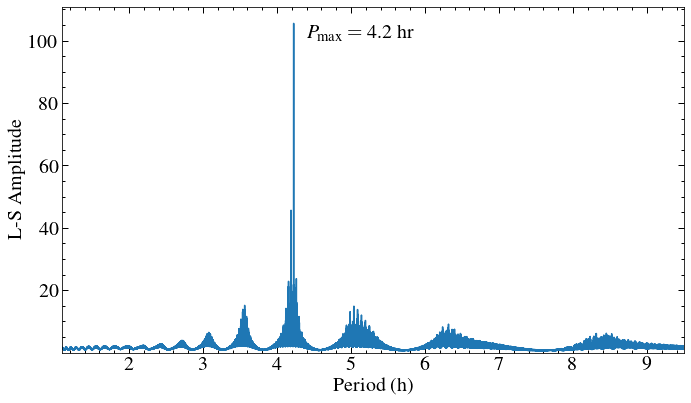

In [91]:
import math
dates  = np.array(wddvs['MJD'])
nights = np.array([math.floor(date) for date in dates])
#print(nights)
cols =  []
for i , n in enumerate(np.unique(nights)):
    for night in nights:
        if night == n:
            cols.append('C{}'.format(i))
cols = np.array(cols)
#print(cols)

#fitter = fitting.LevMarLSQFitter()

frequency, power = LombScargle(mdt, mdv,dy=mde, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)
period = 1/frequency[np.argmax(power)]
print(period)

plt.figure(figsize=(10, 6))

#plt.subplot(121)
plt.plot(1/frequency, np.sqrt(power))
plt.xlabel('Period (h)')
plt.ylabel('L-S Amplitude')
plt.xlim(1.1, 9.5)
plt.ylim(0.01)
plt.annotate(r'$P_{\mathrm{max}} = $'+'{0:10.1f} hr'.format(period), (4.4, 100), xycoords = 'data')
#plt.xscale('log')
#plt.yscale('log')
#plt.axhline(np.sqrt(fa99), ls='--', c='0.5')

#plt.subplot(122)
#for i in range(len(mdt)):
 #   plt.errorbar((mdt[i]/period %1), mdv[i], yerr=mde[i], marker='o', ls='none', color=cols[i])
#plt.xlabel('Phase')
#plt.ylabel('Velocity (km\,s$^{-1}$)')
plt.tight_layout()


Same for the wd lines, can't hurt to try

5.133290318421386


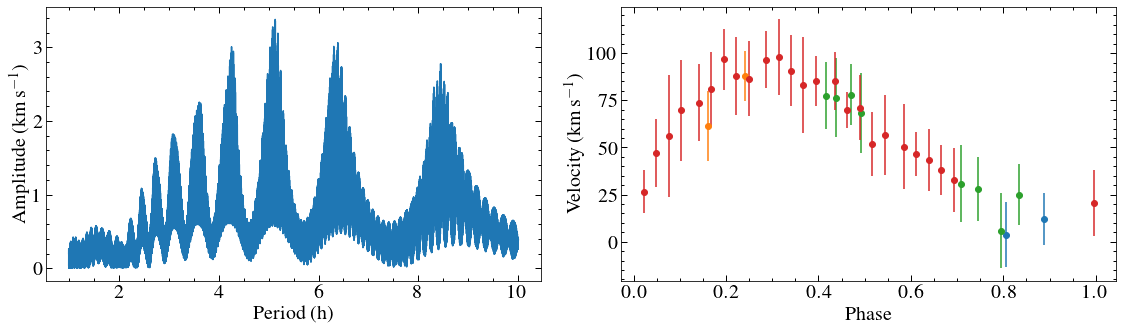

In [26]:
import math
dates  = np.array(wddvs['MJD'])
nights = np.array([math.floor(date) for date in dates])
#print(nights)
cols =  []
for i , n in enumerate(np.unique(nights)):
    for night in nights:
        if night == n:
            cols.append('C{}'.format(i))
cols = np.array(cols)
#print(cols)

#fitter = fitting.LevMarLSQFitter()

frequency, power = LombScargle(wdt, wdv,dy=wde, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)
wdperiod = 1/frequency[np.argmax(power)]
print(wdperiod)

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(1/frequency, np.sqrt(power))
plt.xlabel('Period (h)')
plt.ylabel('Amplitude (km\,s$^{-1}$)')
#plt.axhline(np.sqrt(fa99), ls='--', c='0.5')

plt.subplot(122)
for i in range(len(wdt)):
    plt.errorbar((wdt[i]/wdperiod %1), wdv[i], yerr=wde[i], marker='o', ls='none', color=cols[i])
plt.xlabel('Phase')
plt.ylabel('Velocity (km\,s$^{-1}$)')
plt.tight_layout()

Nope. Fold on m dwarf period and fit.

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=197.3720162, frequency=1., phase=0.10112108)>

    [1]: <Const1D(amplitude=26.92188675)>
Parameters:
       amplitude_0     frequency_0       phase_0          amplitude_1    
    ------------------ ----------- ------------------- ------------------
    197.37201619998925         1.0 0.10112107672088312 26.921886749526752
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-35.62786875, frequency=1., phase=0.09986514)>

    [1]: <Const1D(amplitude=58.30763377)>
Parameters:
       amplitude_0     frequency_0       phase_0          amplitude_1   
    ------------------ ----------- ------------------- -----------------
    -35.62786875473051         1.0 0.09986513627680692 58.30763376704854
gr redshift 31.38574701752179 2.0525537887699206
M dwarf amplitude 197.37201619998925 0.7712

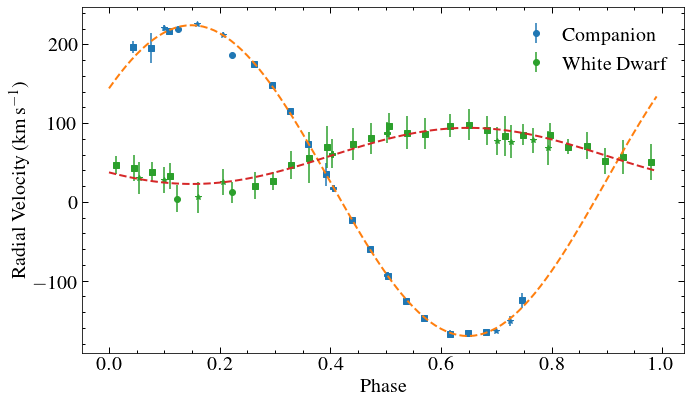

In [67]:
def make_syms(data):
    dates  = np.array(data['MJD'])
    nights = np.array([math.floor(date) for date in dates])
    syms =  []
    symlist = ['o', 'P', '*', 's']
    for i , n in enumerate(np.unique(nights)):
        for night in nights:
            if night == n:
                syms.append(symlist[i])
    return np.array(syms)


plt.figure(figsize=(10,6))

foldt = mdt/period % 1


syms = make_syms(mddvs)
for i in range(len(mdt)):
    if i == 0:
        plt.errorbar(foldt[i], mdv[i], yerr=mde[i], marker=syms[i], ls='none', c='C0', label='Companion')
    else:
        plt.errorbar(foldt[i], mdv[i], yerr=mde[i], marker=syms[i], ls='none', c='C0')

sin_mod =  models.Sine1D(amplitude=150, frequency=1, fixed=dict(frequency=True)) +  models.Const1D(50)
sin_fit = fitter(sin_mod, foldt, mdv, weights= 1/mde, maxiter=1000000)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
timefit = np.arange(0,1, 0.01)
plt.plot(timefit, sin_fit(timefit), ls='--', lw=2, zorder=5, c='C1')
plt.xlim()
print(sin_fit)


wfoldt = wdt/period % 1


syms = make_syms(wddvs)
for i in range(len(wdt)):
    if i == 0:
        plt.errorbar(wfoldt[i], wdv[i], yerr=wde[i], marker=syms[i], ls='none', c='C2', label='White Dwarf')
    else:
        plt.errorbar(wfoldt[i], wdv[i], yerr=wde[i], marker=syms[i], ls='none', c='C2')
#plt.errorbar(wfoldt, wdv, yerr=wde, marker='o', ls='none')

wdsin_mod =  models.Sine1D(amplitude=10, frequency=1, fixed=dict(frequency=True)) +  models.Const1D(40)#, bounds = dict(amplitude=[30, 50]))
wdsin_fit = fitter(wdsin_mod, wfoldt, wdv, weights= 1/wde, maxiter=1000000)
wdfit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(timefit, wdsin_fit(timefit), ls='--', lw=2, zorder=5, C='C3')
plt.xlim()
print(wdsin_fit)

gr = wdsin_fit[1].amplitude - sin_fit[1].amplitude
gre = (wdfit_e[2]**2 + fit_e[2]**2)**0.5
print('gr redshift', gr, gre )

md_amp = sin_fit[0].amplitude.value 
md_amp_e = (fit_e[0]**2 + fit_e[1]**2)**0.5
print('M dwarf amplitude', md_amp, md_amp_e  )


wd_amp = abs(wdsin_fit[0].amplitude) 
wd_amp_e = (wdfit_e[0]**2 + wdfit_e[1]**2)**0.5
print('W dwarf amplitude', wd_amp, wd_amp_e  )

plt.legend()
plt.xlabel('Phase')
plt.ylabel('Radial Velocity (km\,s$^{-1}$)')
plt.tight_layout()

Nicola's catalouge predicts a GR redshift of 16.1. Guo+ predicts 20. Can we constrain the fit? No?

In [52]:
mwdn =  0.45
mwdg = 0.49
v_ratio = wd_amp/md_amp
percent_error = ((md_amp_e/md_amp)**2+(wd_amp_e/wd_amp)**2)**0.5
for wdm in [mwdn, mwdg]:
    md_mass = v_ratio *wdm
    md_mass_error = md_mass * percent_error
    print(md_mass, md_mass_error)

0.08123006112165156 0.00501191836328745
0.08845051099913169 0.00545742221780189
